In [1]:
'''
Here we will define functions which will allow us to analyse a given soil spectroscopy and what the spectral graph means in terms of chemical componentss/features like pH, Nitrogen content, etc.

Spectral readings -> features

'''


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import dask.dataframe as dd
import sklearn

ossl_data = pd.read_csv(r"ossl_all_L0_v1.2.csv")
print(ossl_data.shape)

C:\Users\jagda\AppData\Local\Temp\ipykernel_49940\327847178.py:15: DtypeWarning: Columns (1,4,5,6,15,16,17,21,25,62,111,112,113,114,115,116,117,118,119,120,121,1823,1824,1825,1826,1827,1828,1829,1830,1831,1832,1833) have mixed types. Specify dtype option on import or set low_memory=False.
  ossl_data = pd.read_csv(r"ossl_all_L0_v1.2.csv")


(135651, 2910)


In [2]:
sample_data = ossl_data.sample(n=1000, random_state=1)
print(sample_data.shape)

(1000, 2910)


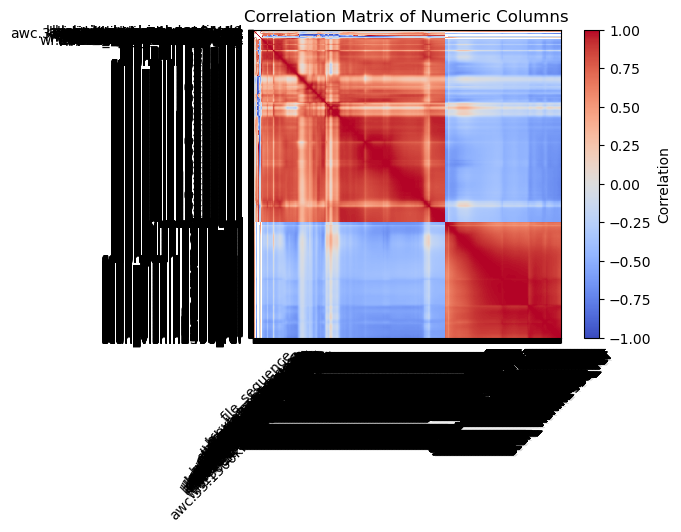

In [ ]:

numerical_ossl = sample_data.select_dtypes(include=['float64', 'int64'])
corr_matrix = numerical_ossl.corr()


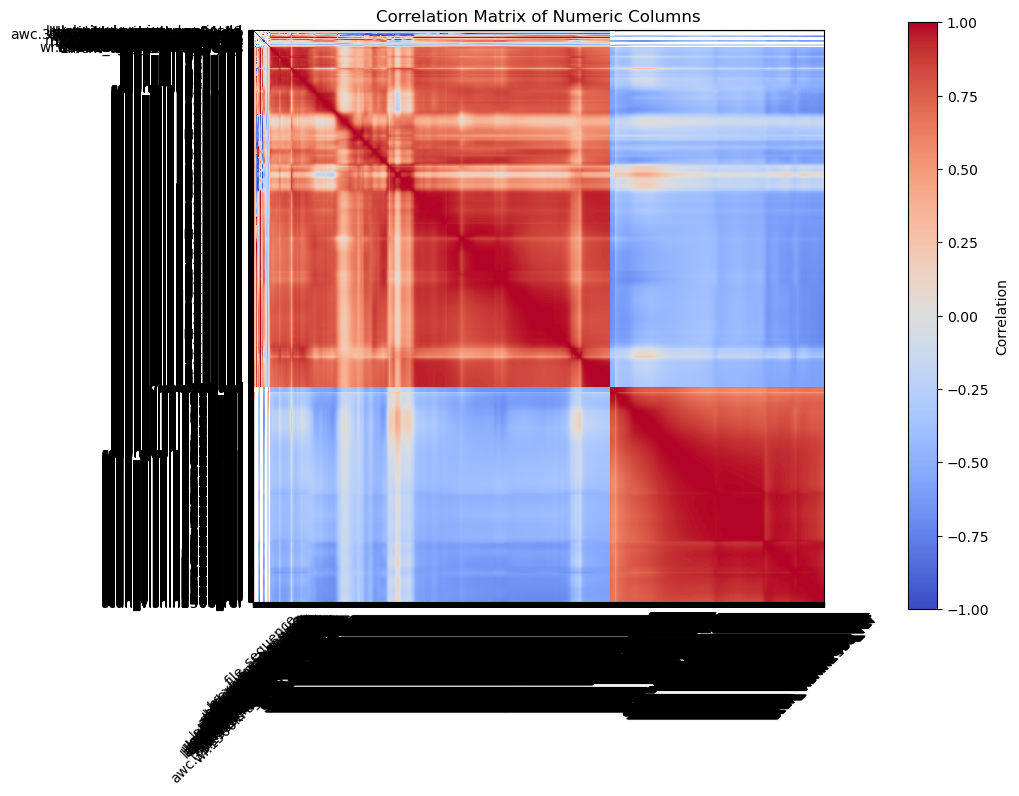

In [12]:
fig, ax = plt.subplots(figsize=(10, 8), constrained_layout=True)

plt.imshow(corr_matrix, cmap="coolwarm", interpolation="none")
plt.colorbar(label="Correlation")
plt.xticks(range(len(corr_matrix)), corr_matrix.columns, rotation=45)
plt.yticks(range(len(corr_matrix)), corr_matrix.columns)
plt.title("Correlation Matrix of Numeric Columns")
plt.show()

In [4]:
visnir = ossl_data[[col for col in ossl_data.columns if "visnir" in col]]
print(visnir.shape)

notmir =  ossl_data[[col for col in ossl_data.columns if "mir" not in col]]
print(notmir)

(135651, 1087)
       dataset.code_ascii_txt id.layer_local_c  \
0                  AFSIS1.SSL        icr072246   
1                  AFSIS1.SSL        icr072247   
2                  AFSIS1.SSL        icr072266   
3                  AFSIS1.SSL        icr072267   
4                  AFSIS1.SSL        icr072286   
...                       ...              ...   
135646              LUCAS.SSL      2015.648817   
135647              LUCAS.SSL      2015.649017   
135648              LUCAS.SSL      2015.649017   
135649              LUCAS.SSL      2015.649617   
135650              LUCAS.SSL      2015.649817   

                       id.layer_uuid_txt  \
0       ded584d70bf0474202d30e575ae24784   
1       7c080e182bc23e19747629f46edbc6c4   
2       03bbd570dfd399bfd866ebcdf860de39   
3       887d316328ef950eeca33293bfe052bf   
4       ca03ce6e439b1909c5a4a771c0afa951   
...                                  ...   
135646  13b75cfc186ce496b308579a63521dad   
135647  ce7853e20ef27df1940eff8c

In [5]:
nulls = notmir.isnull().sum()

print(nulls)
print(notmir.shape) 

nonscanned = notmir[[col for col in notmir.columns if "scan" not in col]]
print(nonscanned.shape)

dataset.code_ascii_txt        0
id.layer_local_c              0
id.layer_uuid_txt             0
id.project_ascii_txt          0
id.location_olc_txt       47944
                          ...  
scan_visnir.2492_ref      71007
scan_visnir.2494_ref      71007
scan_visnir.2496_ref      71007
scan_visnir.2498_ref      71007
scan_visnir.2500_ref      71007
Length: 1198, dtype: int64
(135651, 1198)
(135651, 110)


In [6]:
'''print(nonscanned.columns)
nonscanned.head()
nulls_non = nonscanned.isnull().sum()   
print(nonscanned)'''

'print(nonscanned.columns)\nnonscanned.head()\nnulls_non = nonscanned.isnull().sum()   \nprint(nonscanned)'

In [ ]:
'''
Features:
    Exchangeable Aluminium (al.ext_aquaregia_g.kg,
                            al.ext_usda.a1056_mg.kg,
                            al.ext_usda.a69_cmolc.kg)

    Bulk Density (bd_usda.a21_g.cm3,
                  bd_usda.a4_g.cm3)

    carbon weight % (c.tot_usda.a622_w.pct) #has caco3 influence

    Nutrient Contents: 
                        Ca:
                            (ca.ext_usda.a1059_mg.kg,
                            ca.ext_usda.a722_cmolc.kg)

                        Cu:
                            (cu.ext_usda.a1063_mg.kg)

                        Fe:
                            (fe.ext_usda.a1064_mg.kg, 
                            fe.ox_usda.a60_w.pct)
                        K: 
                            (k.ext_usda.a1065_mg.kg,
                              k.ext_usda.a725_cmolc.kg)*,
                        Mg: 
                            (mg.ext_usda.a1066_mg.kg,
                              mg.ext_usda.a724_cmolc.kg)*,
                        Mn:
                            (mn.ext_usda.a1067_mg.kg,
                            mn.ext_usda.a70_mg.kg)
                        N:
                            (n.tot_iso.11261_w.pct, *
                            n.tot_usda.a623_w.pct) ***
                        Na:
                            (na.ext_usda.a726_cmolc.kg)
                        P:
                            (p.ext_iso.11263_mg.kg, 
                            p.ext_usda.a1070_mg.kg,
                            p.ext_usda.a274_mg.kg) *
                        S:
                            s.tot_usda.a624_w.pct
                        Zn:
                            zn.ext_usda.a1073_mg.kg


    Organic Carbon:
                (oc_iso.10694_w.pct, *
                oc_usda.c1059_w.pct, 
                oc_usda.c729_w.pct)*
    pH: 
        ph.cacl2_iso.10390_index *
        ph.cacl2_usda.a477_index
        ph.cacl2_usda.a481_index
        ph.h2o_iso.10390_index
        ph.h2o_usda.a268_index

    Electrical Conductivity (ec_iso.11265_ds.m,
                            ec_usda.a364_ds.m)
    Carbonate Content (caco3_iso.10693_w.pct,
                        caco3_usda.a54_w.pct)
    Cation Exchange Capacity (cec_iso.11260_cmolc.kg,
                            cec_usda.a723_cmolc.kg)
    Coarse Fragments (cf_iso.11464_w.pct,
                        cf_usda.c236_w.pct)
    Clay Content (clay_iso.11277_w.pct,
                    clay.tot_usda.a334_w.pct)
    Sand Content:
                sand.tot_iso.11277_w.pct
                sand.tot_usda.c405_w.pct
                sand.tot_usda.c60_w.pct *
                silt.tot_iso.11277_w.pct *

    Silt Content:
                silt.tot_usda.c407_w.pct
                silt.tot_usda.c62_w.pct *

    Water Retention:
                wr.10kPa_usda.a414_w.pct
                wr.10kPa_usda.a8_w.pct
                wr.1500kPa_usda.a417_w.pct
                wr.33kPa_usda.a415_w.pct
                wr.33kPa_usda.a9_w.pct
'''

#dropping rows with null values in scan.visnir columns
cleaned_data = notmir.dropna(subset=visnir.columns, how='all')
print(cleaned_data.shape)

#unique datasets in cleaned_data
unique_datasets = cleaned_data["dataset.code_ascii_txt"].unique()
print(unique_datasets)

(64644, 1198)
['ICRAF.ISRIC' 'KSSL.SSL' 'LUCAS.WOODWELL.SSL' 'LUCAS.SSL']
